In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cmocean.cm as cm
import shapely.geometry
from matplotlib.patches import Polygon as MatplotlibPolygon
import geopandas as gpd

from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

from salishsea_tools import viz_tools

# Goal
Turn model results for 2019 into something that shows the spatial and temporal distributions of scrubber washwater in the Salish Sea. We were going to do 3 dyes with different half-lives, so I will probably have this notebook as the master notebook and then make two others for the different dyes.

Our parameter of interest is washwater concentration. We can use the concentrations reported in Hermansson et al. and the initial report (cite) to set contours of washwater concentration.

In [27]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mesh.tmask[0]
volume = ((1-tmask) * mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0]).rename({'z':'depth'})

In [3]:
## read in the input washwater file
ww_in = xr.open_dataset('/ocean/cdonaldson/scrubbers/yearly_obs/scrubber_1d_obs_tempsalcalc_20190101_20191231.nc')

In [41]:
## read in the year of results and select which washwater parameter to look at
ww_out = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/01jan19d/SalishSea_1h_20190101_20190101_scrb_T.nc')

In [42]:
ww_out

<xarray.Dataset>
Dimensions:               (y: 898, x: 398, nvertex: 4, deptht: 40,
                           axis_nbounds: 2, time_counter: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * deptht                (deptht) float32 0.5 1.5 2.5 3.5 ... 387.6 414.5 441.5
    time_centered         (time_counter) datetime64[ns] ...
  * time_counter          (time_counter) datetime64[ns] 2019-01-01T00:30:00 2...
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    bounds_nav_lon        (y, x, nvertex) float32 ...
    bounds_nav_lat        (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    deptht_bounds         (deptht, axis_nbounds) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] ...
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] ...
    no_decay              (time_counter, deptht, y, x) float32 ...
    slow_decay            (time_counter, deptht, y, x) float32 ...
    medium_decay          (time_counter, deptht, y, x) float32 ...
    fast_decay            (time_counter, deptht, y, x) float32 ...
Attributes:
    name:         SalishSea_1h_20190101_20190101_scrb_T
    description:  scrubber water tracers
    title:        scrubber water tracers
    Conventions:  CF-1.6
    timeStamp:    2026-Feb-14 03:59:49 GMT
    uuid:         c25edc52-4699-47d9-b86c-2f49753c48ae

In [15]:
ww_out.no_decay.max()

<xarray.DataArray 'no_decay' ()>
array(5379.82568359)

In [16]:
ww_out.no_decay.isnull().count()

<xarray.DataArray 'no_decay' ()>
array(28592320)

In [17]:
ww_out.no_decay

<xarray.DataArray 'no_decay' (time_counter: 2, deptht: 40, y: 898, x: 398)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
    nav_lat        (y, x) float32 ...
    nav_lon        (y, x) float32 ...
  * deptht         (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2019-01-01T00:30:00 2019-01-...
Dimensions without coordinates: y, x
Attributes:
    long_name:           Scrubberwater no decay
    units:               m3/m3
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    cell_measures:       area: area

In [18]:
ww_out.no_decay.fillna(0).max()

<xarray.DataArray 'no_decay' ()>
array(5379.82568359)

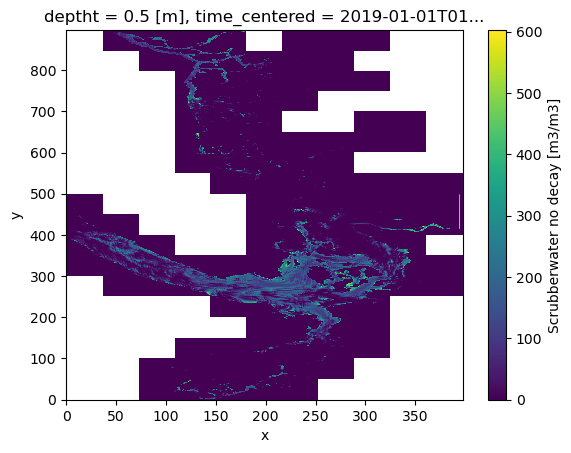

In [19]:
ww_out.no_decay.isel(deptht=0, time_counter=1).plot()

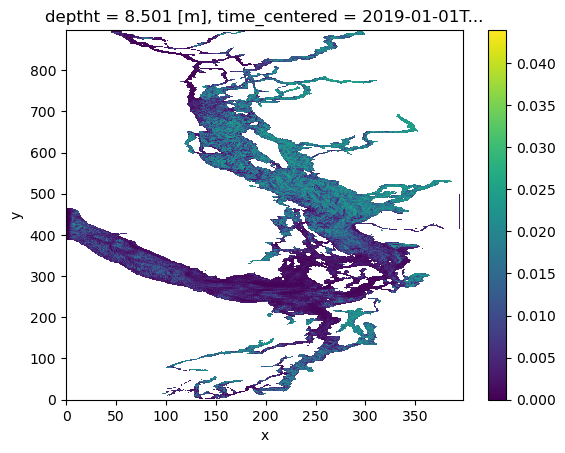

In [43]:
conc = ww_out.no_decay.isel(deptht=8, time_counter=1)/volume.isel(depth=8)
conc.plot()

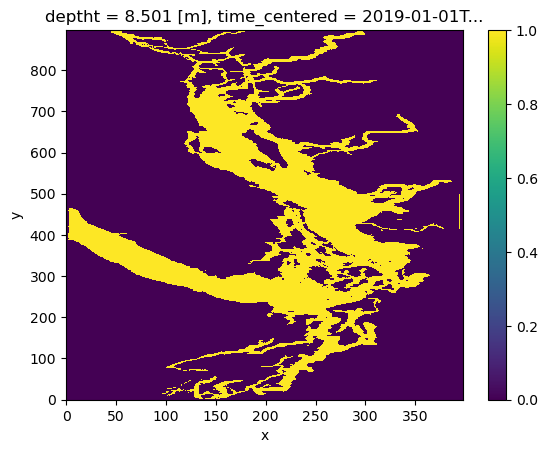

In [44]:
bool = conc >= 0.0003
bool.plot()

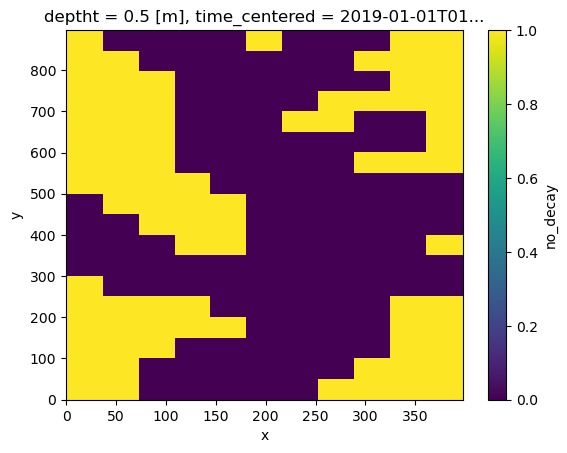

In [20]:
ww_out.no_decay.isel(deptht=0, time_counter=1).isnull().plot()

In [29]:
phys = xr.open_dataset('/data/sallen/results/MEOPAR/Scrubberwater/01jan19/SalishSea_1h_20190101_20190101_grid_T.nc')

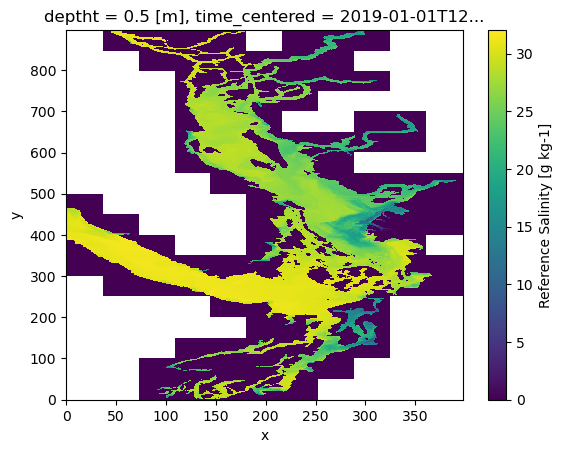

In [34]:
phys.isel(deptht=0, time_counter=12).vosaline.plot()

In [5]:
## depthwise sum of the whole domain, might need to do in a different notebook. save this output then read it back in

In [6]:
## turn the whole domain into concentrations, might need to do this in a different notebook. save this output and read it back in

In [7]:
## split into average concentration by layer slices. maybe 0-10m, 10-20m, 20-30m, 

#### Defns

In [8]:
matter_color = mcolors.to_hex(cm.matter(0.75))
haline_color = mcolors.to_hex(cm.haline(0.15))
thermal_color = mcolors.to_hex(cm.thermal(0.80))

### Plot: show the input data
Panel A: sum of all washwater volume over the domain
Panel B: histogram of individual washwater inputs
Panel C: histogram of temperature inputs
Panel D: histogram of salinity inputs

In [9]:
# fname = 'washwater_in'
# writervideo = animation.FFMpegWriter(fps=10)
# depth = 0 
# cmap = cm.matter
# cmap.set_bad('lightgray')
# cmap.set_under('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))
# washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=0, depth=depth)), mask=tmask[0])
# colours = ax.pcolormesh(washwater, cmap=cmap, vmax=150, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax, label=r'Washwater [m$^3$]')
# viz_tools.set_aspect(ax);

# def newframe(frame_num):
#     washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=frame_num, depth=depth)), mask=tmask[depth])
#     colours.set_array(washwater.ravel())
#     dtime = pd.to_datetime(ww_in['time'].values[frame_num])
#     ax.set_title(str(dtime.date()))
#     viz_tools.set_aspect(ax);

# ani = FuncAnimation(fig, newframe, frames=len(ww_in['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/dfo-cd/animations/{}.mp4'.format(fname), writer=writervideo)

In [10]:
# fname = 'washwater_in_depth8.5'
# writervideo = animation.FFMpegWriter(fps=10)
# depth = 0
# cmap = cm.matter
# cmap.set_bad('lightgray')
# cmap.set_under('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))
# washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=0, depth=depth)), mask=tmask[8])
# colours = ax.pcolormesh(washwater, cmap=cmap, vmax=150, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax, label=r'Washwater [m$^3$]')
# viz_tools.set_aspect(ax);

# def newframe(frame_num):
#     washwater = np.ma.masked_array(np.nan_to_num(ww_in.washwater.isel(time=frame_num, depth=depth)), mask=tmask[8])
#     colours.set_array(washwater.ravel())
#     dtime = pd.to_datetime(ww_in['time'].values[frame_num])
#     ax.set_title(str(dtime.date()))
#     viz_tools.set_aspect(ax);

# ani = FuncAnimation(fig, newframe, frames=len(ww_in['time']), repeat=False)
# ani.save('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/dfo-cd/animations/{}.mp4'.format(fname), writer=writervideo)

In [11]:
ww_in_sum = ww_in.washwater.sum(dim='time')

In [12]:
washwater_flat = ww_in.washwater.values.flatten()
temp_out_flat = ww_in.temp_out.values.flatten()
sal_out_flat = ww_in.sal_out.values.flatten()

washwater_flat = washwater_flat[~np.isnan(washwater_flat)]
temp_out_flat = temp_out_flat[~np.isnan(temp_out_flat)]
sal_out_flat = sal_out_flat[~np.isnan(sal_out_flat)]

In [13]:
# cmap = cm.matter
# cmap.set_bad('lightgray')
# cmap.set_under('gray')

# fig, ax = plt.subplots(1,1, figsize = (5, 9))
# washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
# colours = ax.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax, label=r'Washwater [m$^3$]')
# US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
# patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='-.')
# ax.add_patch(patch)

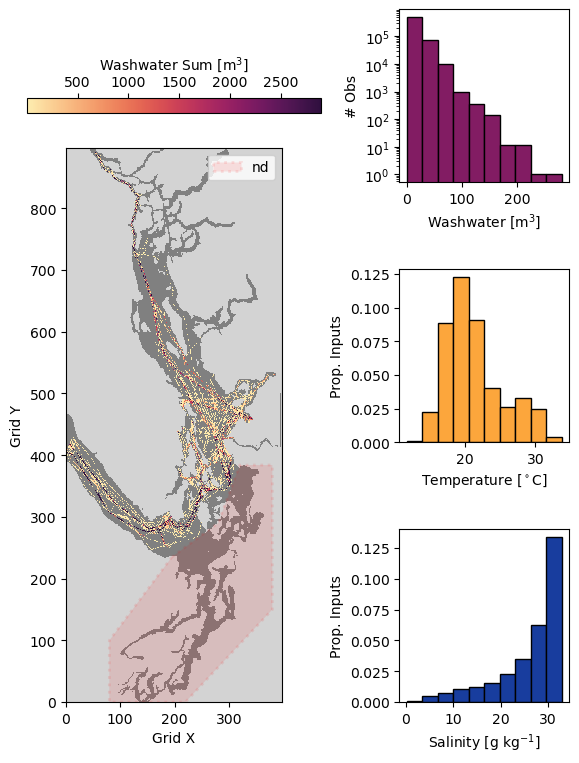

In [14]:
cmap = cm.matter
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig = plt.figure(figsize = (7, 9))
grid = plt.GridSpec(3,5, wspace=1.7, hspace=0.5)
ax1 = plt.subplot(grid[0:,0:3])
ax2 = plt.subplot(grid[0,3:])
ax3 = plt.subplot(grid[1,3:])
ax4 = plt.subplot(grid[2,3:])

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
colours = ax1.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
cb = fig.colorbar(colours, ax=ax1, label=r'Washwater Sum [m$^3$]', location='top')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='nd')
ax1.add_patch(patch)
ax1.set_ylabel('Grid Y')
ax1.set_xlabel('Grid X')
viz_tools.set_aspect(ax1);

ax2.hist(washwater_flat, 10, density=False, log=True, color=matter_color, edgecolor='k')
ax2.set_xlabel(r'Washwater [m$^3$]')
ax2.set_ylabel('# Obs')

ax3.hist(temp_out_flat, 10, density=True, log=False, color=thermal_color, edgecolor='k')
ax3.set_xlabel(r'Temperature [$^\circ$C]')
ax3.set_ylabel('Prop. Inputs')

ax4.hist(sal_out_flat, 10, density=True, log=False, color=haline_color, edgecolor='k')
ax4.set_xlabel(r'Salinity [g kg$^{-1}$]')
ax4.set_ylabel('Prop. Inputs')

ax1.legend()

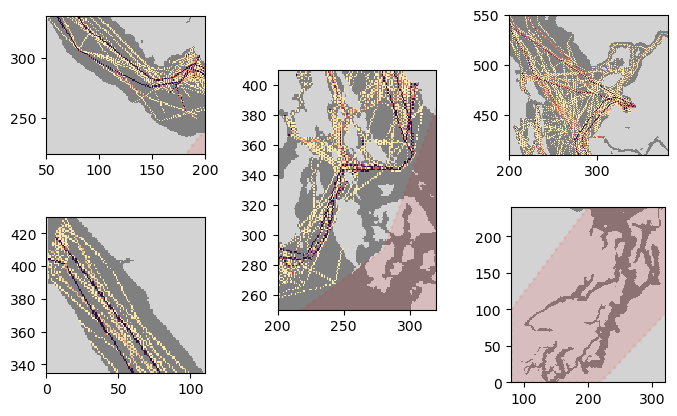

In [15]:
cmap = cm.matter
cmap.set_bad('lightgray')
cmap.set_under('gray')

fig = plt.figure(figsize = (11, 5))
grid = plt.GridSpec(4,8, wspace=1.7, hspace=0.5)
ax1 = plt.subplot(grid[0:2,0:2])
ax2 = plt.subplot(grid[2:4,0:2])
ax3 = plt.subplot(grid[0:4:,2:4])
ax4 = plt.subplot(grid[0:2:,4:6])
ax5 = plt.subplot(grid[2:4:,4:6])

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
colours = ax1.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax1, label=r'Washwater Sum [m$^3$]', location='left')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax1.add_patch(patch)
ax1.set_xlim([50,200])
ax1.set_ylim([220,335])
viz_tools.set_aspect(ax1);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
colours = ax2.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax2, label=r'Washwater Sum [m$^3$]', location='left')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax2.add_patch(patch)
ax2.set_xlim([0,110])
ax2.set_ylim([335,430])
viz_tools.set_aspect(ax2);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
colours = ax3.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax3, label=r'Washwater Sum [m$^3$]')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax3.add_patch(patch)
ax3.set_xlim([200,320])
ax3.set_ylim([250,410])
viz_tools.set_aspect(ax3);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
colours = ax4.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax4, label=r'Washwater Sum [m$^3$]')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax4.add_patch(patch)
ax4.set_xlim([200,380])
ax4.set_ylim([410,550])
viz_tools.set_aspect(ax4);

washwater = np.ma.masked_array(np.nan_to_num(ww_in_sum.isel(depth=0)), mask=tmask[8])
colours = ax5.pcolormesh(washwater, cmap=cmap, vmax=2900, vmin=0.5)
# cb = fig.colorbar(colours, ax=ax5, label=r'Washwater Sum [m$^3$]')
US_exclusion = shapely.geometry.Polygon([(195, 235), (280, 290), (320, 384), (380, 384), (380, 150), (220, 0), (80, 0), (80, 100)])
patch = MatplotlibPolygon(US_exclusion.exterior.coords, closed=True, facecolor='red', alpha=0.1, edgecolor='red', linewidth=2, linestyle='dotted', label='no ww\ndata')
ax5.add_patch(patch)
ax5.set_xlim([80,320])
ax5.set_ylim([0,240])
viz_tools.set_aspect(ax5);

#### SRKW Habitat

In [16]:
crit_hab = gpd.read_file('crit_hab.gdb', layer='DFO_SARA_CH_EDH_EN')

/home/cdonaldson/conda_envs/analysis-2/lib/python3.12/site-packages/pyogrio/raw.py:200: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [26]:
orca = crit_hab['COMMON_E'] == 'Killer Whale'
crit_hab[orca]

,COMMON_E,POP_E,COMMON_F,POP_F,SCIENTIFIC,TAXON_E,ECO_TYPE_E,Waterbody,SARASTAT_E,CHSTATUS_E,COMMENT_E,LEAD_REG_E,SUP_REG_E,PROFILE_E,Area_Km2,Shape_Length,Shape_Area,geometry
864,Killer Whale,Northeast Pacific Northern Resident,Épaulard,résidente du nord du Pacifique Nord-Est,Orcinus orca,Mammals,Marine,Pacific Ocean/Océan Pacifique,Threatened,Final,None,Pacific,None,https://species-registry.canada.ca/index-en.ht...,7319.681360,1.924220e+06,1.774748e+10,"MULTIPOLYGON (((-13985503.47 6274700.411, -139..."
865,Killer Whale,Northeast Pacific Southern Resident,Épaulard,résidente du sud du Pacifique Nord-Est,Orcinus orca,Mammals,Marine,Pacific Ocean/Océan Pacifique,Endangered,Final,None,Pacific,None,https://species-registry.canada.ca/index-en.ht...,7496.738906,1.913499e+06,1.712860e+10,"MULTIPOLYGON (((-13985503.47 6274700.411, -139..."


### Plot: Timeseries of volume input to the model and timeseries of total present sum in the model
This will show different responses for the different half-lives